In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2, EfficientNetB0, DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
# Đường dẫn dữ liệu
data_dir = "/kaggle/input/pytorch-challange-flower-dataset/dataset"
img_size = (224, 224)
batch_size = 32
epochs = 10

# Data augmentation cho tập train
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Chỉ rescale cho tập validation và test
valid_datagen = ImageDataGenerator(rescale=1.0/255)

# Load dữ liệu
train_generator = train_datagen.flow_from_directory(
    directory=f"{data_dir}/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

valid_generator = valid_datagen.flow_from_directory(
    directory=f"{data_dir}/valid",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_generator = valid_datagen.flow_from_directory(
    directory=f"{data_dir}/test",
    target_size=img_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

Found 6552 images belonging to 102 classes.
Found 818 images belonging to 102 classes.
Found 0 images belonging to 0 classes.



--- Training VGG16 ---
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


205/205 ━━━━━━━━━━━━━━━━━━━━ 129s 563ms/step - accuracy: 0.0320 - loss: 4.5700 - val_accuracy: 0.0917 - val_loss: 4.1397 - learning_rate: 0.0010
Epoch 2/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 79s 370ms/step - accuracy: 0.0979 - loss: 4.0830 - val_accuracy: 0.2323 - val_loss: 3.5436 - learning_rate: 0.0010
Epoch 3/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 79s 371ms/step - accuracy: 0.1691 - loss: 3.6011 - val_accuracy: 0.3276 - val_loss: 3.0601 - learning_rate: 0.0010
Epoch 4/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 79s 373ms/step - accuracy: 0.2203 - loss: 3.2569 - val_accuracy: 0.3863 - val_loss: 2.7206 - learning_rate: 0.0010
Epoch 5/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 79s 372ms/step - accuracy: 0.2642 - loss: 3.0191 - val_accuracy: 0.4291 - val_loss: 2.4617 - learning_rate: 0.0010
Epoch 6/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 79s 372ms/step - accuracy: 0.2912 - loss: 2.8302 - val_accuracy: 0.4597 - val_loss: 2.3004 - learning_rate: 0.0010
Epoch 7/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 79s 373ms/step - accuracy: 0.3305 - loss

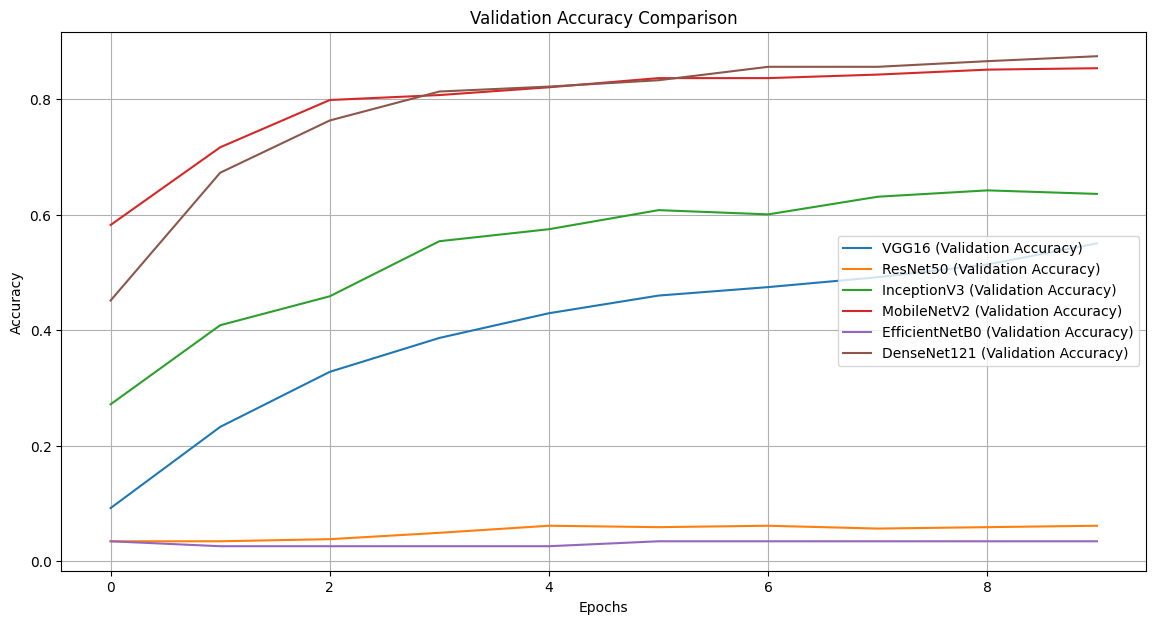

In [3]:
models_list = [
    ("VGG16", VGG16),
    ("ResNet50", ResNet50),
    ("InceptionV3", InceptionV3),
    ("MobileNetV2", MobileNetV2),
    ("EfficientNetB0", EfficientNetB0),
    ("DenseNet121", DenseNet121)
]

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.5,          
    patience=3,         
    min_lr=1e-6          
)

results = {}

for model_name, model_fn in models_list:
    print(f"\n--- Training {model_name} ---")
    
    base_model = model_fn(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Đóng băng các layer pre-trained
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(train_generator.num_classes, activation="softmax")
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=epochs,
        verbose=1,
        callbacks=[reduce_lr]
    )
    
    results[model_name] = {
        "accuracy": history.history["accuracy"],
        "val_accuracy": history.history["val_accuracy"],
        "loss": history.history["loss"],
        "val_loss": history.history["val_loss"]
    }

# Vẽ biểu đồ so sánh
plt.figure(figsize=(14, 7))

for model_name, result in results.items():
    plt.plot(result["val_accuracy"], label=f"{model_name} (Validation Accuracy)")

plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()
